In [ ]:
!pip install lalsuite pyfstat optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

gcs_bucket = 'gravity-proj'
colab_folder = 'new'

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!mkdir {colab_folder}
!gcsfuse --implicit-dirs {gcs_bucket} {colab_folder}

Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2426  100  2426    0     0  55136      0 --:--:-- --:--:-- --:--:-- 55136
OK
26 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
Need to get 13.3 MB of archives.
After this operation, 30.7 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.10_amd64.deb ...
Unpacking gcsfuse (0.41.10) ...
Setting up gcsfuse (0.41.10) ...
2023/01/06 01:21:55.162343 Start gcsfuse/0.41.10 (Go version go1.1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfstat

import os, sys
import time, h5py, math
from tqdm import tqdm
import optuna
import lalpulsar

%matplotlib inline

In [ ]:
dir = './new/'
df = pd.read_csv(f'{dir}train_labels.csv')
df = df[df['target'] >= 0]

In [ ]:
file_id = 'e0cdcda46'
filename = f'{dir}train/{file_id}.hdf5'
f = h5py.File(filename, 'r')
g = f[file_id]

In [ ]:
print(g["frequency_Hz"][0], g["frequency_Hz"][-1])

123.425 123.62444444444444


In [ ]:
img = np.empty((2, 360, 128), dtype=np.float32)
for idx, s in enumerate(['H1', 'L1']):
    a = g[s]['SFTs'][:, :4096] * 1e22

    p = a.real**2 + a.imag**2
    p /= np.mean(p)
    p = np.mean(p.reshape(360, 128, 32), axis=2)

    img[idx] = p

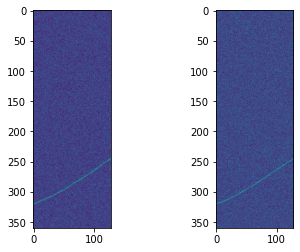

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(img[0])
ax2.imshow(img[1])

# Create SFT File

In [ ]:
label = "PyFstat_example_grid_search_F0F1"
outdir = os.path.join('PyFstat_example_data', label)

writer_kwargs = {
    'label': 'single_detector_gaussian_noise',
    'outdir': 'PyFstat_example_data',
    'timestamps': {
        'H1': g['H1']['timestamps_GPS'][:],
        'L1': g['L1']['timestamps_GPS'][:]
    },
    'detectors': 'H1,L1',
    'sqrtSX': 1e-22,
    'Tsft': 1800,
    'SFTWindowType': 'tukey',
    'SFTWindowBeta': 0.01,
    'F0': (g['frequency_Hz'][0] + g['frequency_Hz'][-1]) / 2,
    'Band': 0.6,
}
writer = pyfstat.Writer(**writer_kwargs)
writer.make_data()

In [ ]:
freqs, times, sft_d = pyfstat.utils.get_sft_as_arrays(writer.sftfilepath)

In [ ]:
len(times['H1']), len(times['L1'])

(4600, 4571)

In [ ]:
len(freqs)

1081

In [ ]:
amplitudes = {k:v for k, v in sft_d.items()}

In [ ]:
amplitudes['H1'].shape, amplitudes["L1"].shape

((1081, 4600), (1081, 4571))

In [ ]:
img = np.empty((2, 1080, 128), dtype=np.float32)
for idx, s in enumerate(['H1', 'L1']):
    a = amplitudes[s][:1080, :4096] * 1e22

    p = a.real**2 + a.imag**2
    p /= np.mean(p)
    print(p.shape)
    p = np.mean(p.reshape(1080, 128, 32), axis=2)
    img[idx] = p

(1080, 4096)
(1080, 4096)


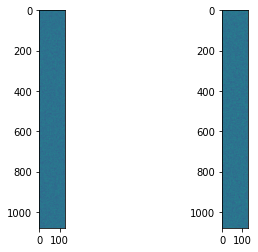

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[0])
ax2.imshow(img[1])

# Load and Write SFT Data

In [ ]:
import lalpulsar

constraints = lalpulsar.SFTConstraints()
sft_catalog = lalpulsar.SFTdataFind(writer.sftfilepath, constraints)
len(sft_catalog.data)

9171

In [ ]:
fMin = fMax = -1
multi_sfts = lalpulsar.LoadMultiSFTs(sft_catalog, fMin, fMax)
print(len(multi_sfts.data))
print(len(multi_sfts.data[0].data))
print(len(multi_sfts.data[0].data[0].data.data))

2
4600
1081


In [ ]:
print(g["H1"]['SFTs'].shape)
print(g["L1"]['SFTs'].shape)

(360, 4600)
(360, 4571)


In [ ]:
arr = g['H1']['SFTs'][:]
for j in tqdm(np.arange(len(multi_sfts.data[0].data))):
    for k in np.arange(360):
        val = arr[k][j]
        multi_sfts.data[0].data[j].data.data[k] = val
        multi_sfts.data[0].data[j].data.data[k+360] = val
        multi_sfts.data[0].data[j].data.data[k+360*2] = val

arr = g['L1']['SFTs'][:]

for j in tqdm(np.arange(len(multi_sfts.data[1].data))):
    for k in np.arange(360):
        val = arr[k][j]
        multi_sfts.data[1].data[j].data.data[k] = val
        multi_sfts.data[1].data[j].data.data[k+360] = val
        multi_sfts.data[1].data[j].data.data[k+360*2] = val

100%|██████████| 4571/4571 [6:31:14<00:00,  5.14s/it]


In [ ]:
# from concurrent.futures import ThreadPoolExecutor

# def task1(j, k):
#     val = arr[k][j]
#     multi_sfts.data[0].data[j].data.data[k] = val
#     multi_sfts.data[0].data[j].data.data[k+360] = val
#     multi_sfts.data[0].data[j].data.data[k+360*2] = val
#     return multi_sfts

# def task2(j, k):
#     val = arr[k][j]
#     multi_sfts.data[1].data[j].data.data[k] = val
#     multi_sfts.data[1].data[j].data.data[k+360] = val
#     multi_sfts.data[1].data[j].data.data[k+360*2] = val
#     return multi_sfts
# for j in tqdm(np.arange(len(multi_sfts.data[0].data))):
#     for k in np.arange(360):
        
# with ThreadPoolExecutor

# arr = g['H1']['SFTs'][:]

# arr = g['L1']['SFTs'][:]

# for j in tqdm(np.arange(len(multi_sfts.data[1].data))):
#     for k in np.arange(360):
        
        
        
        

In [ ]:
!mkdir h1.sft
!mkdir l1.sft

lalpulsar.WriteSFTVector2File(multi_sfts.data[0],"h1.sft","comment","misc")
lalpulsar.WriteSFTVector2File(multi_sfts.data[1],"l1.sft","comment","misc")

0

In [ ]:
h1_fname = !ls h1.sft
l1_fname = !ls l1.sft

my_sftfilepath = f"h1.sft/{h1_fname[0]};l1.sft/{l1_fname[0]}"
my_sftfilepath

'h1.sft/H-4600_H1_1800SFT_misc-1238166384-10414599.sft;l1.sft/L-4571_L1_1800SFT_misc-1238173716-10370220.sft'

In [ ]:
freqs, times, sft_data = pyfstat.utils.get_sft_as_arrays(my_sftfilepath)

amplitudes = {k:v for k, v in sft_data.items()}
img = np.empty((2, 1080, 128), dtype=np.float32)
for idx, s in enumerate(['H1', 'L1']):
    a = amplitudes[s][:1080, :4096] * 1e22
    p = a.real**2 + a.imag**2
    p /= np.mean(p)
    p = np.mean(p.reshape(1080, 128, 32), axis=2)
    img[idx] = p

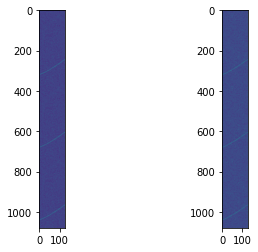

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[0])
ax2.imshow(img[1])

# Step 3 Matched-Filter Search

In [ ]:
def search(f0, f1, nsegs, alphas, deltas, visualize=False):
    tstart = (g['H1']['timestamps_GPS'][0] + g['L1']['timestamps_GPS'][0]) / 2
    tend = (g['H1']['timestamps_GPS'][-1] + g['L1']['timestamps_GPS'][-1]) / 2
    tref = 0.5 (tstart - tend)

    f0s = [f0]
    f1s = [f1]
    f2s = [0]

    search = pyfstat.GridSearch(
        label=label,
        outdir=outdir,
        sftfilepattern=my_sftfilepath,
        F0s=F0s,
        F1s=F1s,
        F2s=F2s,
        Alphas=alphas,
        Deltas=deltas,
        tref=tref,
        nsegs=nsegs,
        detectors="H1,L1",
    )
    search.run()

    if visualize:
        search.plot_2D(xkey='Alpha', ykey='Delta', colorbar=True)
    return np.max(search.data['twoF'])

<>:4: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:4: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<ipython-input-27-f58fe9939093>:4: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  tref = 0.5 (tstart - tend)


In [ ]:
now_f0 = (g["frequency_Hz"][0] + g["frequency_Hz"][-1])/2
now_f1 = -1e-10

now_f0,now_f1

(123.52472222222221, -1e-10)

In [ ]:
alphas = [0, 2*math.pi, 2*math.pi / 100]
deltas = [-math.pi/2, math.pi/2, math.pi / 100]

search(now_f0,now_f1, 1000,alphas,deltas,True)

TypeError: ignored

In [ ]:
def objective(trial):
    alphas = [0, 2*math.pi, 2*math.pi / 100]
    deltas = [-math.pi/2, math.pi/2, math.pi / 100]
    
    f0 = trial.suggest_float('f0', now_f0 - 0.1, now_f0 + 0.1)
    f1 = trial.suggest_float('f1', -4e-9, 0)
    result = search(f0,f1, 1000,alphas,deltas,False)

    return result

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout= 3 * 60 * 60)

result = study.trials_dataframe()
result.sort_values("value",ascending=False).head(10)

In [ ]:
result.sort_values("value",ascending=False).to_csv('optuna_results.csv', index=None)

In [ ]:
plt.scatter(result.params_f0, result.params_f1, c=result.value)
plt.colorbar()
plt.xlabel('f0')
plt.ylabel('f1')
plt.grid()

In [ ]:
best_f0 = study.best_params["f0"]
best_f1 = study.best_params["f1"]

best_f0,best_f1

In [ ]:
alphas = [0, 2*math.pi, 2*math.pi / 100]
deltas = [-math.pi/2, math.pi/2, math.pi / 100]
search(best_f0,best_f1, 1000,alphas,deltas,True)